<h1><center><font size="6">Predicting Credit Card Fraud</font></center></h1>

<h3><center><font size="4"> https://www.kaggle.com/mlg-ulb/creditcardfraud </font></center></h2>

In [1]:
# Feature engineering uses Polynomial Features rather than Feature Tools

<a id="top"></a> <br>
## Table of  Contents
1. [Introduction](#1)
1. [Initialization](#2)
    1. [Load Packages](#21)
    1. [Define Metadata](#22)
    
1. [Load Data & Validate](#3)
    
1. [Feature Engineering](#4)
    1. [Prepping - Memory Reduction](#41)
    1. [Feature Generation](#42)
        1. [Custom Mathematical Transformation](#422)
        1. [Polynomial Feature Generation](#422)
    
1. [Feature Reduction](#5)
    1. [Eliminating Duplicates and Constant Columns](#51)
    1. [Collinearity-based Reduction](#52)
    1. [Feature Importance-based Reduction](#53)
    1. [Custom Reduction](#54)

1. [Test Performance](#6)
    1. [Data Prep](#61)
        1. [Train Test Split](#611)
        1. [Resample Train Data](#612)
    1. [Modelling Workflow](#62)
    
1. [Export Data & Model](#7)

1. [References](#8)

# <a id='1'>Introduction</a>  

We will use feature tools library to expand the feature space using the built-in transformations. Then once the synthetic features are created, we will to reduce the feature space by removing collinear columns, feature importances and Recursive Feature Elimination. Finally we will run the Random Forest Classifier to get test performance on datasets that have been resampled using the technique identified in the previous week


# <a id='2'>Initialization</a>  

### <a id='21'>Load Packages</a>  

Load the minimum number of packages to get started and add more as we go along

In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
# This is to suppress any deprecation warnings 

import os
import sys
sys.path.append("/home/paperspace/Kaggle Grandmaster/Udemy Superstar/Classification") # Adds higher directory to python modules path.


### <a id='22'>Define Metadata</a>  

In [3]:
# Define the name of the target class column here instead of manually typing it out everywhere
target_class_name = 'Class'

# Fill in the names of what you want to call the 0 and 1 class
labels = ['Non-Fraud', 'Fraud']

input_file_name = 'creditcard.csv'

intermediate_data_path = '../intermediate data/'

engineered_df_file_name = 'week3_engineered_df_'
output_df_file_name = 'week3_cleaned_df_output_' 
fitted_model_name = 'week3_rf_on_engineered_df_'

# Enter the date in which this notebook is run
export_date = '20200413'

In [4]:
# Check ou tthe names of the files in the input folder that we need to load as dataframe
print(os.listdir('../input'))
# This will list all the files in this folder

['creditcard.csv']


## <a id='3'>Load Data & Validate</a>  

In [5]:
df = pd.read_csv('../input/' + input_file_name)
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
17910,29025.0,-1.108916,0.527368,2.151904,-0.879536,0.365788,-0.293905,0.764261,-0.131232,0.173664,...,-0.343089,-0.521400,0.022825,0.141356,0.236735,0.762055,-0.043040,-0.146084,0.89,0
221890,142738.0,2.235100,-0.828424,-2.676338,-1.265261,0.408522,-0.766725,0.091080,-0.313800,-0.866495,...,0.316820,0.705679,-0.269178,-1.369215,0.521656,0.146222,-0.105605,-0.100724,60.44,0
56617,47507.0,0.215475,1.055140,0.524741,0.837173,0.484447,-0.892613,1.139340,-0.370807,-0.699007,...,0.151396,0.810257,-0.015714,0.559999,-0.785218,-0.475125,0.274607,-0.000030,3.74,0
105987,69771.0,-2.965541,-7.444787,-1.114973,2.258566,-3.089458,1.951209,1.632339,-0.051028,-0.595480,...,0.854021,-1.569074,-1.725050,-0.220109,-0.620540,-0.639562,-0.270696,0.393356,2128.41,0
284107,172159.0,0.032158,0.794803,0.275036,-0.571487,0.324901,-1.143418,0.975897,-0.166778,0.066998,...,-0.265349,-0.631737,0.092113,0.018256,-0.513633,0.140096,0.240428,0.096334,8.08,0


Lets check the head & tail to make sure there is nothing going on

In [6]:
df.head(3)
# What you are checking here is whether there are some unwanted headers from teh input file that 
# can corrupt our data
# If found, either open the file and manually delete it or only load the relevant columns

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [7]:
df.tail(3)
# similar logic here

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


No data corruption seen in either the head or the tail

## <a id='4'> Feature Engineering  

### <a id='41'> Prepping

We are going to reduce our memory footprint of the stored dataframe to ease the burden on the processing. Subsequently, we are also cut down on the number of features we want to apply feature engineering on by using the top features identified by a ML classifier like RandomForestClassifier

#### <a id='411'> Memory Reduction

In [8]:
# Check out what the data types are before the more efficient storage occurs
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [9]:
# #Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

from helper_functions_comprehensive import reduce_mem_usage_function
# reduce_mem_usage_function(dataframe, print_ongoing_column_change = True, percentile_threshold = 0.01)

df, NA_dict = reduce_mem_usage_function(df)
# There is 2x reduction in the size of the data
# All the float64 got converted to float32

Memory usage of dataframe is 67.36 MB
Column Time dtype after is uint32 
******************************
Column V1 dtype after is float32 
******************************
Column V2 dtype after is float32 
******************************
Column V3 dtype after is float32 
******************************
Column V4 dtype after is float32 
******************************
Column V5 dtype after is float32 
******************************
Column V6 dtype after is float32 
******************************
Column V7 dtype after is float32 
******************************
Column V8 dtype after is float32 
******************************
Column V9 dtype after is float32 
******************************
Column V10 dtype after is float32 
******************************
Column V11 dtype after is float32 
******************************
Column V12 dtype after is float32 
******************************
Column V13 dtype after is float32 
******************************
Column V14 dtype after is float32 
************

###### Split Target Features

In [10]:
X = df.drop(target_class_name, axis=1)
y = df[target_class_name]
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998


#### <a id=412 > Selecting top 10 features - Feature Importances

Depending on the resources available, you can go all out and apply feature tools on all the features. But I would recommend just doing it for the top 10 features as defined by the Feature Importances from a simple ML algorithm. Note that since we are not using the fitted model for inferencing, there is no need to do train_test_split. I am going to apply the RandomForestClassifier on the whole dataset

In [11]:
# Lets define a simple classifier based on the above augmented data

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 42)

# Fit on the input data
classifier.fit(X, y)

# Get the feature importances
feature_importances = classifier.feature_importances_

# Create a dataframe to hold the feature importances
feature_importances_df = pd.DataFrame({'feature': list(X.columns), 
                    'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances_df.head(10)
# Print from the highest to the lowest feature importance

,feature,importance
14,V14,0.238511
17,V17,0.146950
10,V10,0.116904
12,V12,0.084148
16,V16,0.045395
7,V7,0.036199
26,V26,0.029767
20,V20,0.023970
21,V21,0.023676
4,V4,0.019622


In [12]:
imp_column_list = list(feature_importances_df.head(10)['feature'].values)
imp_column_list
# Now use these moving forward for the automated feature engineering

['V14', 'V17', 'V10', 'V12', 'V16', 'V7', 'V26', 'V20', 'V21', 'V4']

In [13]:
imp_X = X[imp_column_list].copy()
unimp_X = X[list(set(X.columns) - set(imp_column_list))].copy()
# the latter will be later used to concatenate with the engineered features before feature reduction

# pd.concat([engineered_df, inimp_X], axis=1)

assert((len(imp_X.columns) + len(unimp_X.columns)) ==  len(X.columns))

len(imp_X.columns), len(unimp_X.columns), len(X.columns)


(10, 20, 30)

### <a id=42 >Feature Generation

Feature Engineering can based on domain knowledge or clever intuition based on the understanding of the data. But given that this is a Kaggle dataset with anonymized features we cant do either. The next best option is to do combinations of features using mathematical operations which is what we are going to attempt here.

#### <a id=421 > Custom Mathematical Feature Generation

In [14]:
# create a copy of the dataframe that will be holding our engineered variables
engineered_df = imp_X.copy()
engineered_df.head()

,V14,V17,V10,V12,V16,V7,V26,V20,V21,V4
0,-0.311169,0.207971,0.090794,-0.617801,-0.470401,0.239599,-0.189115,0.251412,-0.018307,1.378155
1,-0.143772,-0.114805,-0.166974,1.065235,0.463917,-0.078803,0.125895,-0.069083,-0.225775,0.448154
2,-0.165946,1.109969,0.207643,0.066084,-2.890083,0.791461,-0.139097,0.524980,0.247998,0.379780
3,-0.287924,-0.684093,-0.054952,0.178228,-1.059647,0.237609,-0.221929,-0.208038,-0.108300,-0.863291
4,-1.119670,-0.237033,0.753074,0.538196,-0.451449,0.592941,0.502292,0.408542,-0.009431,0.403034


In [15]:
%%time
for col in engineered_df.columns:
    print(col)
    
    engineered_df['square_'+col] = engineered_df[col].apply(lambda x: x*x)

    min_val = engineered_df[col].min()
    # Apply log transformation while ensuring no NaNs are generated
    engineered_df['log_'+col] = engineered_df[col].apply(lambda x: np.log(x-min_val+1))
    
    # Similarly, subtract the min to make sure that the sqrt is always positive
    engineered_df['sqrt_'+col] = engineered_df[col].apply(lambda x: np.sqrt(x-min_val))
        
    # If else function for the reciprocal to work correctly
    engineered_df['reciproc_'+col] = engineered_df[col].apply(lambda x: 1./x if np.abs(x) else 0)
    
print('No. of columns now are {}'.format(len(engineered_df.columns)))

# The number of columns makes sense because 10 original columns *4 operations = 40 new columns
# This takes a while to run because the element-wise operations are slow

V14
V17
V10
V12
V16
V7
V26
V20
V21
V4
No. of columns now are 50
CPU times: user 1min 22s, sys: 3.73 s, total: 1min 26s
Wall time: 38.1 s


In [16]:
engineered_df.head()

,V14,V17,V10,V12,V16,V7,V26,V20,V21,V4,...,sqrt_V20,reciproc_V20,square_V21,log_V21,sqrt_V21,reciproc_V21,square_V4,log_V4,sqrt_V4,reciproc_V4
0,-0.311169,0.207971,0.090794,-0.617801,-0.470401,0.239599,-0.189115,0.251412,-0.018307,1.378155,...,7.399266,3.977533,0.000335,3.578285,5.900176,-54.624575,1.899312,2.087078,2.657316,0.725608
1,-0.143772,-0.114805,-0.166974,1.065235,0.463917,-0.078803,0.125895,-0.069083,-0.225775,0.448154,...,7.377577,-14.475314,0.050974,3.572475,5.882568,-4.429184,0.200842,1.964497,2.476151,2.231375
2,-0.165946,1.109969,0.207643,0.066084,-2.890083,0.791461,-0.139097,0.524980,0.247998,0.379780,...,7.417729,1.904836,0.061503,3.585694,5.922701,4.032288,0.144233,1.954863,2.462306,2.633106
3,-0.287924,-0.684093,-0.054952,0.178228,-1.059647,0.237609,-0.221929,-0.208038,-0.108300,-0.863291,...,7.368153,-4.806819,0.011729,3.575769,5.892545,-9.233572,0.745272,1.761280,2.195423,-1.158358
4,-1.119670,-0.237033,0.753074,0.538196,-0.451449,0.592941,0.502292,0.408542,-0.009431,0.403034,...,7.409876,2.447727,0.000089,3.578533,5.900928,-106.036699,0.162436,1.958150,2.467024,2.481181


#### <a id=422 > Polynomial Feature Generation

sklearn has a good package called Polynomial Features which is good at generating cross terms

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

How does this work? Basically, the method creates all possible cross terms upto the polynomial degree passed in as a parameter

In [17]:
%%time
from sklearn.preprocessing import PolynomialFeatures

poly_object = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# Note that I have changed the include_bias to False, otherwise it creates a column of 1s

engineered_df = pd.DataFrame(poly_object.fit_transform(engineered_df), 
                             columns = list(poly_object.get_feature_names(engineered_df.columns)))
engineered_df.head()
# you start seeing both square terms as well as cross-terms between the variables

# How do you figure out the number of new columns being generated?
# https://math.stackexchange.com/questions/1424824/general-formula-for-number-of-terms-in-an-expansion
 
# Number of terms in the expansion (a1+a2+...a50)^2 = 1275 because (n+k-1)C(k-1) = (2+50-1)C(50-1) = 51C49 = 1275?

CPU times: user 1min 37s, sys: 7.82 s, total: 1min 45s
Wall time: 13.5 s


In [18]:
print('There are currently {} columns'.format(len(engineered_df.columns)))
# Note some redundant columns will be generated because we took the square of some square root terms from before   

There are currently 1275 columns


##### Reduce Memory

In [19]:
%%time
# Lets try reducing the memory footprint
features, NAlist = reduce_mem_usage_function(engineered_df)

Memory usage of dataframe is 2770.45 MB
Column V14 dtype after is float32 
******************************
Column V17 dtype after is float32 
******************************
Column V10 dtype after is float32 
******************************
Column V12 dtype after is float32 
******************************
Column V16 dtype after is float32 
******************************
Column V7 dtype after is float32 
******************************
Column V26 dtype after is float32 
******************************
Column V20 dtype after is float32 
******************************
Column V21 dtype after is float32 
******************************
Column V4 dtype after is float32 
******************************
Column square_V14 dtype after is float32 
******************************
Column log_V14 dtype after is float32 
******************************
Column sqrt_V14 dtype after is float32 
******************************
Column reciproc_V14 dtype after is int32 
******************************
Column square_V

Column V17 reciproc_V17 dtype after is float32 
******************************
Column V17 square_V10 dtype after is float32 
******************************
Column V17 log_V10 dtype after is float32 
******************************
Column V17 sqrt_V10 dtype after is float32 
******************************
Column V17 reciproc_V10 dtype after is int32 
******************************
Column V17 square_V12 dtype after is float32 
******************************
Column V17 log_V12 dtype after is float32 
******************************
Column V17 sqrt_V12 dtype after is float32 
******************************
Column V17 reciproc_V12 dtype after is int32 
******************************
Column V17 square_V16 dtype after is float32 
******************************
Column V17 log_V16 dtype after is float32 
******************************
Column V17 sqrt_V16 dtype after is float32 
******************************
Column V17 reciproc_V16 dtype after is int32 
******************************
Column V17 s

Column V12 square_V26 dtype after is float32 
******************************
Column V12 log_V26 dtype after is float32 
******************************
Column V12 sqrt_V26 dtype after is float32 
******************************
Column V12 reciproc_V26 dtype after is int32 
******************************
Column V12 square_V20 dtype after is float32 
******************************
Column V12 log_V20 dtype after is int8 
******************************
Column V12 sqrt_V20 dtype after is int16 
******************************
Column V12 reciproc_V20 dtype after is int32 
******************************
Column V12 square_V21 dtype after is float32 
******************************
Column V12 log_V21 dtype after is int8 
******************************
Column V12 sqrt_V21 dtype after is int8 
******************************
Column V12 reciproc_V21 dtype after is int32 
******************************
Column V12 square_V4 dtype after is int16 
******************************
Column V12 log_V4 dtype afte

Column V26 reciproc_V14 dtype after is int32 
******************************
Column V26 square_V17 dtype after is float32 
******************************
Column V26 log_V17 dtype after is float32 
******************************
Column V26 sqrt_V17 dtype after is float32 
******************************
Column V26 reciproc_V17 dtype after is int32 
******************************
Column V26 square_V10 dtype after is float32 
******************************
Column V26 log_V10 dtype after is float32 
******************************
Column V26 sqrt_V10 dtype after is float32 
******************************
Column V26 reciproc_V10 dtype after is int32 
******************************
Column V26 square_V12 dtype after is float32 
******************************
Column V26 log_V12 dtype after is float32 
******************************
Column V26 sqrt_V12 dtype after is float32 
******************************
Column V26 reciproc_V12 dtype after is int32 
******************************
Column V26 squ

Column V21 log_V20 dtype after is float32 
******************************
Column V21 sqrt_V20 dtype after is int16 
******************************
Column V21 reciproc_V20 dtype after is int32 
******************************
Column V21 square_V21 dtype after is float32 
******************************
Column V21 log_V21 dtype after is float32 
******************************
Column V21 sqrt_V21 dtype after is float32 
******************************
Column V21 reciproc_V21 dtype after is float32 
******************************
Column V21 square_V4 dtype after is float32 
******************************
Column V21 log_V4 dtype after is float32 
******************************
Column V21 sqrt_V4 dtype after is float32 
******************************
Column V21 reciproc_V4 dtype after is float32 
******************************
Column V4 square_V14 dtype after is float32 
******************************
Column V4 log_V14 dtype after is float32 
******************************
Column V4 sqrt_V14 dt

Column log_V14 sqrt_V16 dtype after is uint8 
******************************
Column log_V14 reciproc_V16 dtype after is int32 
******************************
Column log_V14 square_V7 dtype after is float32 
******************************
Column log_V14 log_V7 dtype after is uint8 
******************************
Column log_V14 sqrt_V7 dtype after is uint8 
******************************
Column log_V14 reciproc_V7 dtype after is int32 
******************************
Column log_V14 square_V26 dtype after is float32 
******************************
Column log_V14 log_V26 dtype after is float32 
******************************
Column log_V14 sqrt_V26 dtype after is float32 
******************************
Column log_V14 reciproc_V26 dtype after is int32 
******************************
Column log_V14 square_V20 dtype after is float32 
******************************
Column log_V14 log_V20 dtype after is uint8 
******************************
Column log_V14 sqrt_V20 dtype after is uint8 
*********

Column square_V17 square_V12 dtype after is float32 
******************************
Column square_V17 log_V12 dtype after is float32 
******************************
Column square_V17 sqrt_V12 dtype after is float32 
******************************
Column square_V17 reciproc_V12 dtype after is int32 
******************************
Column square_V17 square_V16 dtype after is float32 
******************************
Column square_V17 log_V16 dtype after is float32 
******************************
Column square_V17 sqrt_V16 dtype after is float32 
******************************
Column square_V17 reciproc_V16 dtype after is int32 
******************************
Column square_V17 square_V7 dtype after is float32 
******************************
Column square_V17 log_V7 dtype after is float32 
******************************
Column square_V17 sqrt_V7 dtype after is float32 
******************************
Column square_V17 reciproc_V7 dtype after is int32 
******************************
Column squa

Column reciproc_V17 reciproc_V12 dtype after is int32 
******************************
Column reciproc_V17 square_V16 dtype after is int32 
******************************
Column reciproc_V17 log_V16 dtype after is int32 
******************************
Column reciproc_V17 sqrt_V16 dtype after is int32 
******************************
Column reciproc_V17 reciproc_V16 dtype after is int32 
******************************
Column reciproc_V17 square_V7 dtype after is int32 
******************************
Column reciproc_V17 log_V7 dtype after is int32 
******************************
Column reciproc_V17 sqrt_V7 dtype after is int32 
******************************
Column reciproc_V17 reciproc_V7 dtype after is int32 
******************************
Column reciproc_V17 square_V26 dtype after is int32 
******************************
Column reciproc_V17 log_V26 dtype after is int32 
******************************
Column reciproc_V17 sqrt_V26 dtype after is int32 
******************************
Colum

Column sqrt_V10 sqrt_V26 dtype after is float32 
******************************
Column sqrt_V10 reciproc_V26 dtype after is int32 
******************************
Column sqrt_V10 square_V20 dtype after is float32 
******************************
Column sqrt_V10 log_V20 dtype after is uint8 
******************************
Column sqrt_V10 sqrt_V20 dtype after is uint8 
******************************
Column sqrt_V10 reciproc_V20 dtype after is int32 
******************************
Column sqrt_V10 square_V21 dtype after is float32 
******************************
Column sqrt_V10 log_V21 dtype after is uint8 
******************************
Column sqrt_V10 sqrt_V21 dtype after is uint8 
******************************
Column sqrt_V10 reciproc_V21 dtype after is int32 
******************************
Column sqrt_V10 square_V4 dtype after is float32 
******************************
Column sqrt_V10 log_V4 dtype after is float32 
******************************
Column sqrt_V10 sqrt_V4 dtype after is fl

Column sqrt_V12 log_V7 dtype after is uint8 
******************************
Column sqrt_V12 sqrt_V7 dtype after is uint8 
******************************
Column sqrt_V12 reciproc_V7 dtype after is int32 
******************************
Column sqrt_V12 square_V26 dtype after is float32 
******************************
Column sqrt_V12 log_V26 dtype after is float32 
******************************
Column sqrt_V12 sqrt_V26 dtype after is float32 
******************************
Column sqrt_V12 reciproc_V26 dtype after is int32 
******************************
Column sqrt_V12 square_V20 dtype after is float32 
******************************
Column sqrt_V12 log_V20 dtype after is uint8 
******************************
Column sqrt_V12 sqrt_V20 dtype after is uint8 
******************************
Column sqrt_V12 reciproc_V20 dtype after is int32 
******************************
Column sqrt_V12 square_V21 dtype after is float32 
******************************
Column sqrt_V12 log_V21 dtype after is uin

Column sqrt_V16 log_V21 dtype after is uint8 
******************************
Column sqrt_V16 sqrt_V21 dtype after is uint8 
******************************
Column sqrt_V16 reciproc_V21 dtype after is int32 
******************************
Column sqrt_V16 square_V4 dtype after is float32 
******************************
Column sqrt_V16 log_V4 dtype after is float32 
******************************
Column sqrt_V16 sqrt_V4 dtype after is float32 
******************************
Column sqrt_V16 reciproc_V4 dtype after is int32 
******************************
Column reciproc_V16 square_V7 dtype after is int32 
******************************
Column reciproc_V16 log_V7 dtype after is int32 
******************************
Column reciproc_V16 sqrt_V7 dtype after is int32 
******************************
Column reciproc_V16 reciproc_V7 dtype after is int32 
******************************
Column reciproc_V16 square_V26 dtype after is int32 
******************************
Column reciproc_V16 log_V26 dty

Column square_V26 sqrt_V20 dtype after is float32 
******************************
Column square_V26 reciproc_V20 dtype after is int32 
******************************
Column square_V26 square_V21 dtype after is float32 
******************************
Column square_V26 log_V21 dtype after is float32 
******************************
Column square_V26 sqrt_V21 dtype after is float32 
******************************
Column square_V26 reciproc_V21 dtype after is int32 
******************************
Column square_V26 square_V4 dtype after is float32 
******************************
Column square_V26 log_V4 dtype after is float32 
******************************
Column square_V26 sqrt_V4 dtype after is float32 
******************************
Column square_V26 reciproc_V4 dtype after is float32 
******************************
Column log_V26 sqrt_V26 dtype after is float32 
******************************
Column log_V26 reciproc_V26 dtype after is int32 
******************************
Column log_V26

Column sqrt_V21 log_V4 dtype after is float32 
******************************
Column sqrt_V21 sqrt_V4 dtype after is float32 
******************************
Column sqrt_V21 reciproc_V4 dtype after is int32 
******************************
Column reciproc_V21 square_V4 dtype after is int32 
******************************
Column reciproc_V21 log_V4 dtype after is int32 
******************************
Column reciproc_V21 sqrt_V4 dtype after is int32 
******************************
Column reciproc_V21 reciproc_V4 dtype after is int32 
******************************
Column square_V4 log_V4 dtype after is float32 
******************************
Column square_V4 sqrt_V4 dtype after is float32 
******************************
Column square_V4 reciproc_V4 dtype after is float32 
******************************
Column log_V4 sqrt_V4 dtype after is float32 
******************************
Column log_V4 reciproc_V4 dtype after is int32 
******************************
Column sqrt_V4 reciproc_V4 dtype a

Now lets combine with the rest of the unimportant features

Why are you combining the previously identified low important features if you know that you will be dropping a significant number of features further down the code?

Because the old unimportant features may actually  be higher ranked than some of the newer synthetic features

In [20]:
engineered_df = pd.concat([engineered_df, unimp_X], axis=1)
engineered_df.head()

,V14,V17,V10,V12,V16,V7,V26,V20,V21,V4,...,V15,V9,V27,V1,V2,V22,Amount,V19,V13,V5
0,-0.311169,0.207971,0.090794,-0.617801,-0.470401,0.239599,-0.189115,0.251412,-0.018307,1.378155,...,1.468177,0.363787,0.133558,-1.359807,-0.072781,0.277838,149.619995,0.403993,-0.991390,-0.338321
1,-0.143772,-0.114805,-0.166974,1.065235,0.463917,-0.078803,0.125895,-0.069083,-0.225775,0.448154,...,0.635558,-0.255425,-0.008983,1.191857,0.266151,-0.638672,2.690000,-0.145783,0.489095,0.060018
2,-0.165946,1.109969,0.207643,0.066084,-2.890083,0.791461,-0.139097,0.524980,0.247998,0.379780,...,2.345865,-1.514654,-0.055353,-1.358354,-1.340163,0.771679,378.660004,-2.261857,0.717293,-0.503198
3,-0.287924,-0.684093,-0.054952,0.178228,-1.059647,0.237609,-0.221929,-0.208038,-0.108300,-0.863291,...,-0.631418,-1.387024,0.062723,-0.966272,-0.185226,0.005274,123.500000,-1.232622,0.507757,-0.010309
4,-1.119670,-0.237033,0.753074,0.538196,-0.451449,0.592941,0.502292,0.408542,-0.009431,0.403034,...,0.175121,0.817739,0.219422,-1.158233,0.877737,0.798279,69.989998,0.803487,1.345852,-0.407193


## <a id='5'> Feature Reduction  

### <a id='51'> Identify & Remove Constant or Duplicate Columns  

For our dataset, its highly unlikely we have duplicate columns because they are not categorical

In [21]:
%%time

from helper_functions_comprehensive import find_bad_columns_function

null_col_list, blank_space_col_list, constant_numeric_col_list, \
constant_non_numeric_col_list, duplicate_col_list = find_bad_columns_function(engineered_df)

print('Before dropping irrelevant features and duplicated columns,')
print('{} number of columns were present'.format(len(engineered_df.columns)))

# as expected, there are no duplicate columns or those with nulls

Identified 0 features with atleast one null
Identified 0 features with atleast one blank space
Identified 10 numeric features that have quasi-constant values
Identified 0 non-numeric features that have quasi-constant values
Identified 19 features that are duplicates of other features
Before dropping irrelevant features and duplicated columns,
1295 number of columns were present
CPU times: user 25min 49s, sys: 8.94 s, total: 25min 58s
Wall time: 25min 20s


In [22]:
%%time

# November 11th 2019: Removed null_col_list because I noticed columns that had some but not all NAN
already_dropped_col_set = set()
for drop_column_list in [null_col_list, constant_numeric_col_list, 
                         constant_non_numeric_col_list, duplicate_col_list]:
    
    to_drop_set = set(drop_column_list) - already_dropped_col_set
    
    # Drop the above but only those that have not already been dropped     
    features.drop(to_drop_set, axis=1, inplace=True)
    
    #### Store the deleted columns
    already_dropped_col_set.update(to_drop_set)

print('After dropping the above, ')
print('{} number of columns are present'.format(len(features.columns)))


After dropping the above, 
1255 number of columns are present
CPU times: user 5.33 s, sys: 1.21 s, total: 6.54 s
Wall time: 1.8 s


### <a id='52'> Identify & Remove Collinear Features  

Collinear variables are those which are highly correlated with one another. These can decrease the model's ability to learn, model interpretability, and generalization performance on the test set. 
What criteria should we use to remove them once identified? We will take features having more than 0.8 collinearity with another variable

Some source code is adapted from Chris Albon and Will Koehrsen

https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection

In [23]:
%%time
# Threshold for removing correlated variables. This is arbitrary and can itself be a hyperparam
collinearity_threshold = 0.80

# Absolute value correlation matrix. The default in Pearson but you should use Spearman for Ordinal categoricals
corr_matrix_df = engineered_df.corr().abs()
corr_matrix_df.head()

CPU times: user 15min 42s, sys: 1.29 s, total: 15min 44s
Wall time: 15min 43s


In [24]:
%%time
# Upper triangle of correlations
# np.triu returns a matrix with elements below the kth diagonal zeroed
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu.html

# Create a mask with the above and store just the upper triangular values 
# Because they are the only useful ones anyway

upper_df = corr_matrix_df.where(np.triu(np.ones(corr_matrix_df.shape), k=1).astype(np.bool))
upper_df.head()

CPU times: user 1.45 s, sys: 148 ms, total: 1.6 s
Wall time: 370 ms


In [25]:
%%time
# Select columns with correlations above 80% threshold
collinear_columns_list = [column for column in upper_df.columns 
                          if any(upper_df[column] > collinearity_threshold)]

print('There are {} columns to remove'.format(len(collinear_columns_list)))

There are 1014 columns to remove
CPU times: user 392 ms, sys: 4 ms, total: 396 ms
Wall time: 395 ms


##### Drop the columns

In [26]:
engineered_df = engineered_df.drop(columns = collinear_columns_list)

print('Features shape: ', engineered_df.shape)

Features shape:  (284807, 281)


### <a id='53'> Identify & remove low important features

lets use a simple classifier like Random Forest to figure out the top features

In [27]:
%%time
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(engineered_df, y)

# Record the feature importances
feature_importances = classifier.feature_importances_

feature_importances_df = pd.DataFrame({'feature': list(engineered_df.columns), 
                    'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances_df.head()
# Print from the highest to the lowest

CPU times: user 1min 12s, sys: 1.23 s, total: 1min 13s
Wall time: 58.5 s


In [28]:
# Find the features with zero importance
zero_features_list = list(feature_importances_df[
                        feature_importances_df['importance'] == 0.000]['feature'])
print('There are {} features with 0 importance'.format(len(zero_features_list)))
feature_importances_df.tail()

There are 19 features with 0 importance


,feature,importance
237,log_V7 log_V21,0.0
235,log_V7 log_V20,0.0
198,log_V10 log_V21,0.0
58,V10 reciproc_V10,0.0
34,V14 reciproc_V14,0.0


Depending on the problem we can choose to remove just those features with 0 importance or formally establish a threshold for identify and drop those with low feature importance

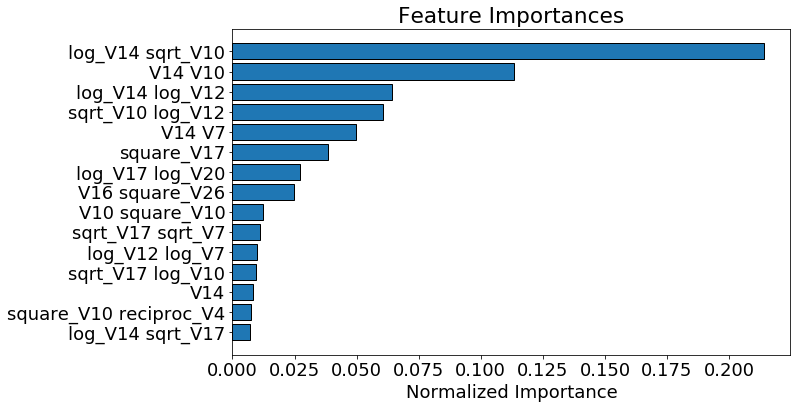

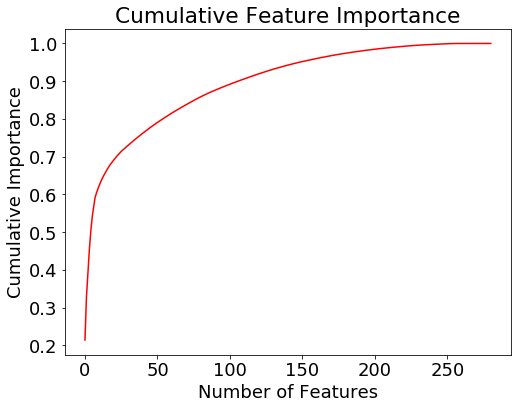

107 features required for 0.9 of cumulative importance


In [29]:
from helper_functions_comprehensive import plot_feature_importances
norm_feature_importances_df,no_of_important_col = plot_feature_importances(feature_importances_df, threshold = 0.90)

In [30]:
norm_feature_importances_df.head()
# Notice how some of the engineered features are supposedly better than the original features

,index,feature,importance,importance_normalized,cumulative_importance
0,147,log_V14 sqrt_V10,0.213998,0.213998,0.213998
1,28,V14 V10,0.113524,0.113524,0.327522
2,148,log_V14 log_V12,0.064227,0.064227,0.391749
3,200,sqrt_V10 log_V12,0.060538,0.060538,0.452286
4,29,V14 V7,0.049624,0.049624,0.501910


In [31]:
# Lets use no_of_important_col as the row index to get the names of the features 
relevant_feature_list = (norm_feature_importances_df['feature'].values)[:no_of_important_col]

In [32]:
import pickle
# This will export the engineered_df 
pickle.dump(engineered_df, open(engineered_df_file_name + export_date + '.pkl', 'wb'))

In [33]:
#Keep these highest importance features
engineered_df = engineered_df[relevant_feature_list].copy()
engineered_df.shape

(284807, 107)

In [34]:
engineered_df.head()

,log_V14 sqrt_V10,V14 V10,log_V14 log_V12,sqrt_V10 log_V12,V14 V7,square_V17,log_V17 log_V20,V16 square_V26,V10 square_V10,sqrt_V17 sqrt_V7,...,V4 reciproc_V20,V2,reciproc_V7 reciproc_V26,log_V12 sqrt_V21,V21 square_V21,square_V12 reciproc_V20,V17 reciproc_V20,V17 V26,V26 reciproc_V7,reciproc_V26 square_V4
0,14,-0.028252,8.816816,14,-0.074556,0.043252,13,-0.016824,0.000748,33,...,5,-0.072781,-22,17,-6.135300e-06,1,0,-0.039330,0,-10
1,14,0.024006,9.095223,14,0.011330,0.013180,13,0.007353,-0.004655,33,...,-6,0.266151,-100,17,-1.150877e-02,-16,1,-0.014453,-1,1
2,14,-0.034457,8.943906,14,-0.131340,1.232032,13,-0.055917,0.008953,34,...,0,-1.340163,-9,17,1.525265e-02,0,2,-0.154393,0,-1
3,14,0.015822,8.942642,14,-0.068413,0.467983,12,-0.052190,-0.000166,32,...,4,-0.185226,-18,17,-1.270255e-03,0,3,0.151820,0,-3
4,14,-0.843195,8.868183,15,-0.663898,0.056185,13,-0.113899,0.427084,33,...,0,0.877737,3,17,-8.387478e-07,0,0,-0.119060,0,0


### <a id = 54> Custom Feature Removal

If at this stage, you find that you have a lot of features, one option is to go back and reduce the information content to be preserved. The other option is to have an arbitrary threshold. Here I am going to keep some of the original features and some of the newer features as long as the total number of features is 30

In [35]:
no_of_feature_cutoff = 30

# The first priority should be the original set of features that are also present in our top 150 from above
final_feature_list = [col for col in relevant_feature_list if col in imp_column_list]

# Only look to add the remaining features that were not in the original top columns list
for i, col in enumerate(relevant_feature_list):
    final_feature_list.append(col)
    print(col)
    if len(final_feature_list)==no_of_feature_cutoff:
        break

log_V14 sqrt_V10
V14 V10
log_V14 log_V12
sqrt_V10 log_V12
V14 V7
square_V17
log_V17 log_V20
V16 square_V26
V10 square_V10
sqrt_V17 sqrt_V7
log_V12 log_V7
sqrt_V17 log_V10
V14
square_V10 reciproc_V4
log_V14 sqrt_V17
V10 V7
V10 V4
reciproc_V16 square_V21
V16 V4
reciproc_V12 square_V21
square_V4
square_V14 reciproc_V7
sqrt_V17 log_V12
V20 reciproc_V4
V16


In [36]:
# the reason why we are so keen on reducing the features is becuase of the curse of dimensionality

## <a id='6'>Test Performance</a> 

### <a id='61'>Data Prep</a> 

#### <a id='611'>Train Test Split</a> 

In [37]:
# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(engineered_df[relevant_feature_list[:25]], y, test_size=0.2, random_state=42)

#### <a id='612'>Resample Training Data</a> 

In [38]:
# April 13th 2020: Resample the X_train, y_train before feeding into the model
from helper_functions_comprehensive import augment_data_function

X_resampled_train, y_resampled_train = augment_data_function(X_train, y_train, 
                                                             positive_upsampling_ratio=4, negative_upsampling_ratio=2)
print(X_resampled_train.shape,sum(y_resampled_train))

(456478, 25) 1576.0


### <a id='62'>Modelling Workflow</a> 

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a classifier object with default params
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_resampled_train, y_resampled_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Has a Train accuracy of 100.0 % 
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    227451
       Fraud       0.99      0.95      0.97       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       1.00      0.98      0.99    227845
weighted avg       1.00      1.00      1.00    227845

The ROC AUC Score on Train set is 1.0
Confusion matrix, without normalization
[[227448      3]
 [    19    375]]


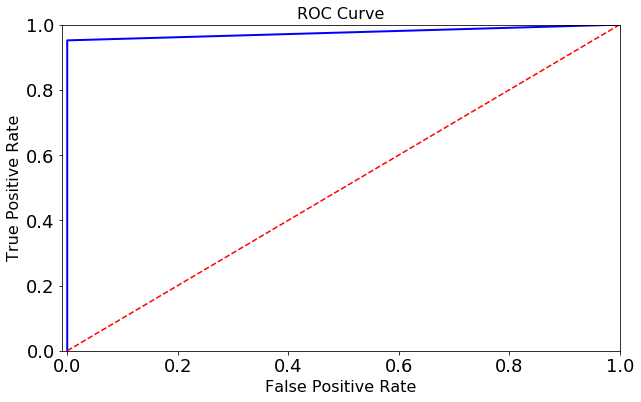

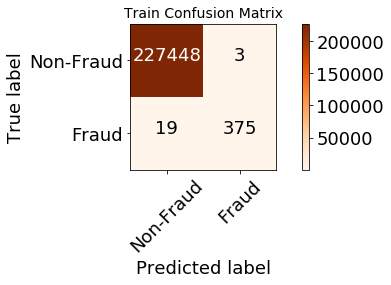

In [40]:
from helper_functions_comprehensive import custom_classification_metrics_function
custom_classification_metrics_function(X_train, y_train, labels, classifier, data_type='Train')

##### Test

Has a Test accuracy of 100.0 % 
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.95      0.81      0.87        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

The ROC AUC Score on Test set is 0.94
Confusion matrix, without normalization
[[56860     4]
 [   19    79]]


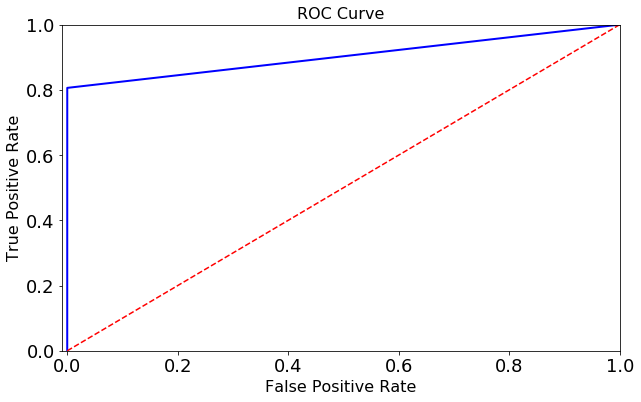

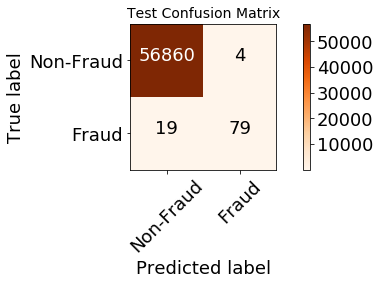

In [41]:
custom_classification_metrics_function(X_test, y_test, labels, classifier, data_type='Test')

Lets also bring in our custom metric to allow us to compare with our week1 model performance

In [42]:
from helper_functions_comprehensive import precision_at_recall_threshold
from helper_functions_comprehensive import classification_report, confusion_matrix, plot_confusion_matrix_function


predicted_proba = classifier.predict_proba(X_test)[:,1]
threshold_precision = precision_at_recall_threshold(y_test, predicted_proba, recall_threshold=0.85)

# For comparison, lets print the precision at the recall threshold of 85%
print(threshold_precision)

0.7870370370370371


In [ ]:
# The test metric is not an improvement over the baseline model yet.

In the interests of time, I have not played around with how many features and subsequently didnt use the feature engineered
dataframe in further weeks. But the reader is invited to try them out with hyperparam tuning

## <a id=7 >Export Data & Pickled Model

In [129]:
import pickle

from helper_functions_comprehensive import data_export_function



# This will export the subset of the engineered_df that was used to feed into the model
data_export_function(X_resampled_train, y_resampled_train, y_train, y_test, 
                         intermediate_data_path, output_df_file_name, export_date)

In [132]:

pickle.dump(classifier, open(fitted_model_name + export_date + '.pkl', 'wb'))
 
# # some time later...
 
# # load the model from disk
# engineered_df = pickle.load(open(filename, 'rb'))
# result = engineered_df.score(X_test, Y_test)

## <a id=8 > References

sklearn documentation on Polynomial Feature Generation
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Examples on stackoverflow in using this 
https://stackoverflow.com/questions/36728287/sklearn-preprocessing-polynomialfeatures-how-to-keep-column-names-headers-of

Removing collinear features
https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection


In [ ]:
# In week 4, we will be starting again from the exported data from week 2 and try hyperparam tuning